In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np


In [2]:
def get_spectogram(audio_path):
    audio_time, sampling_rate = librosa.load(audio_path)
    
    spectogram = librosa.feature.melspectrogram(y=audio_time, sr=sampling_rate, fmax=1024)
    spectogram_dB = librosa.power_to_db(spectogram, ref=np.max)
    return spectogram_dB, sampling_rate


def display_spectogram(audio_path):
    spectogram_dB, sampling_rate = get_spectogram(audio_path)

    plt.figure(figsize=(10, 6))
    librosa.display.specshow(spectogram_dB, sr=sampling_rate, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)e')
    plt.tight_layout()
    plt.show()

    return spectogram_dB, sampling_rate

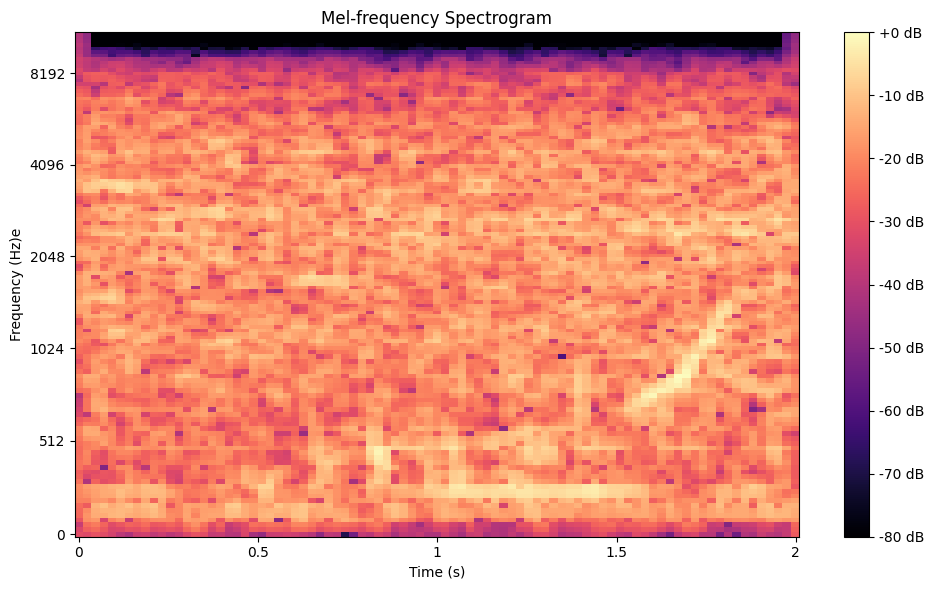

(128, 87)

In [5]:
display_spectogram(audio_path + 'no_right_whale/train1.aiff')[0].shape

In [3]:
import pandas as pd
df = pd.read_csv('./data/train.csv')

In [4]:
df.describe()

,label
count,30000.000000
mean,0.234233
std,0.423526
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [5]:
df

,clip_name,label
0,train1.aiff,0
1,train2.aiff,0
2,train3.aiff,0
3,train4.aiff,0
4,train5.aiff,0
...,...,...
29995,train29996.aiff,0
29996,train29997.aiff,0
29997,train29998.aiff,0
29998,train29999.aiff,0


In [9]:
audio_path = './data/train/'
image, sample_rate = get_spectogram(audio_path + df['clip_name'][0])
sample_rate

22050

In [7]:
#lets get the data into a form that is useful: a tensor of NHWC
N = df.size

#one 'color channel' (decibel value)
C = 1

H = image.shape[0]

W = image.shape[1]

N, H, W, C

(60000, 128, 87, 1)

In [8]:
import torch

data_size = 100
X = torch.Tensor(np.array([np.array([get_spectogram(audio_path + df['clip_name'][i])[0]]) for i in range(data_size)]))
X

tensor([[[[-31.0004, -31.9483, -29.8242,  ..., -40.5897, -37.0633, -27.9183],
          [-32.7441, -27.1738, -25.0458,  ..., -38.0095, -37.2606, -26.8748],
          [-36.4878, -24.0629, -21.9340,  ..., -35.6028, -37.0545, -25.3748],
          ...,
          [-40.0242, -46.3381, -80.0000,  ..., -80.0000, -54.6786, -46.1177],
          [-40.6916, -46.9782, -80.0000,  ..., -80.0000, -55.4886, -46.9847],
          [-40.8674, -47.1150, -80.0000,  ..., -80.0000, -55.7980, -47.3509]]],


        [[[-39.6373, -45.0359, -41.8665,  ..., -45.7509, -42.2301, -34.7747],
          [-39.0533, -42.7356, -39.8293,  ..., -47.4226, -43.6895, -35.2534],
          [-37.9484, -40.4593, -37.6873,  ..., -50.8261, -46.2484, -35.4734],
          ...,
          [-44.3498, -51.4548, -80.0000,  ..., -80.0000, -59.7966, -51.2328],
          [-45.2021, -52.2042, -80.0000,  ..., -80.0000, -60.6890, -52.1791],
          [-45.5379, -52.4430, -80.0000,  ..., -80.0000, -61.0693, -52.6020]]],


        [[[-33.9898, -37.2

In [10]:
y = torch.Tensor(df['label'])
y = y[:data_size]
y = y.to(torch.int)

y_one_hot = torch.zeros(len(y), 2)

# Set the appropriate indices to 1
y_one_hot[range(len(y)), y] = 1
y = y_one_hot

In [11]:
X.shape, y.shape

(torch.Size([30000, 1, 128, 87]), torch.Size([30000, 2]))

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(X_train, y_train)
train_dataset

test_dataset = TensorDataset(X_test, y_test)

In [14]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [31]:
import torch.nn as nn

class ModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=33600, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        #print(x.shape)
        x = self.block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x

torch.manual_seed(69)
model0 = ModelV0(input_shape=1, hidden_units=50, output_shape=2)
model0

ModelV0(
  (block_1): Sequential(
    (0): Conv2d(1, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=33600, out_features=2, bias=Tr

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

/home/taha/ML/.env/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


'cpu'

In [17]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y.argmax(dim=1),
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and acuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y.argmax(dim=1),
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [18]:
def accuracy_fn(y_true, y_pred):
    ans = 0.0
    actual_labels, predictions = y_true, y_pred
    for i in range(len(actual_labels)):
        if actual_labels[i] == predictions[i]:
            ans += 1.0
    
    return ans / len(predictions) * 100

In [32]:
class BCEFocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25, reduction='mean'):
        super(BCEFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Apply sigmoid to inputs
        inputs = torch.sigmoid(inputs)
        
        # Calculate BCE loss
        bce_loss = nn.functional.binary_cross_entropy(inputs, targets, reduction='none')
        
        # Calculate focal loss
        pt = torch.where(targets == 1, inputs, 1 - inputs)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

loss_fn = BCEFocalLoss()
optimizer = torch.optim.Adam(params=model0.parameters(), 
                            lr=0.0001)

In [33]:
epochs = 7
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model0, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model0,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )


Epoch: 0
---------
Train loss: 0.01990 | Train accuracy: 86.25%
Test loss: 0.01547 | Test accuracy: 89.08%

Epoch: 1
---------
Train loss: 0.01426 | Train accuracy: 90.65%
Test loss: 0.01340 | Test accuracy: 90.76%

Epoch: 2
---------
Train loss: 0.01274 | Train accuracy: 91.63%
Test loss: 0.01256 | Test accuracy: 92.10%

Epoch: 3
---------
Train loss: 0.01171 | Train accuracy: 92.38%
Test loss: 0.01240 | Test accuracy: 91.79%

Epoch: 4
---------
Train loss: 0.01082 | Train accuracy: 93.02%
Test loss: 0.01263 | Test accuracy: 91.81%

Epoch: 5
---------
Train loss: 0.00974 | Train accuracy: 93.72%
Test loss: 0.01290 | Test accuracy: 91.87%

Epoch: 6
---------
Train loss: 0.00861 | Train accuracy: 94.60%
Test loss: 0.01340 | Test accuracy: 92.09%



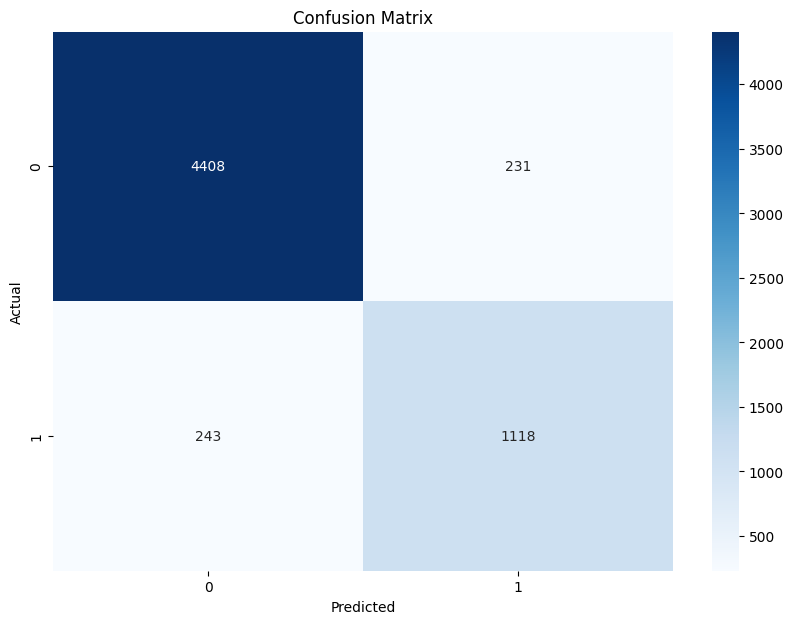

In [34]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

model0.eval()  # Set the model to evaluation mode

all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient calculation
    for X_batch, y_batch in test_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model0(X_batch)
        all_preds.append(y_pred.argmax(dim=1).cpu().numpy())
        all_labels.append(y_batch.argmax(dim=1).cpu().numpy())

# Flatten the lists
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [35]:
torch.save(model0.state_dict(), "./modelv2-slow92%.pt")